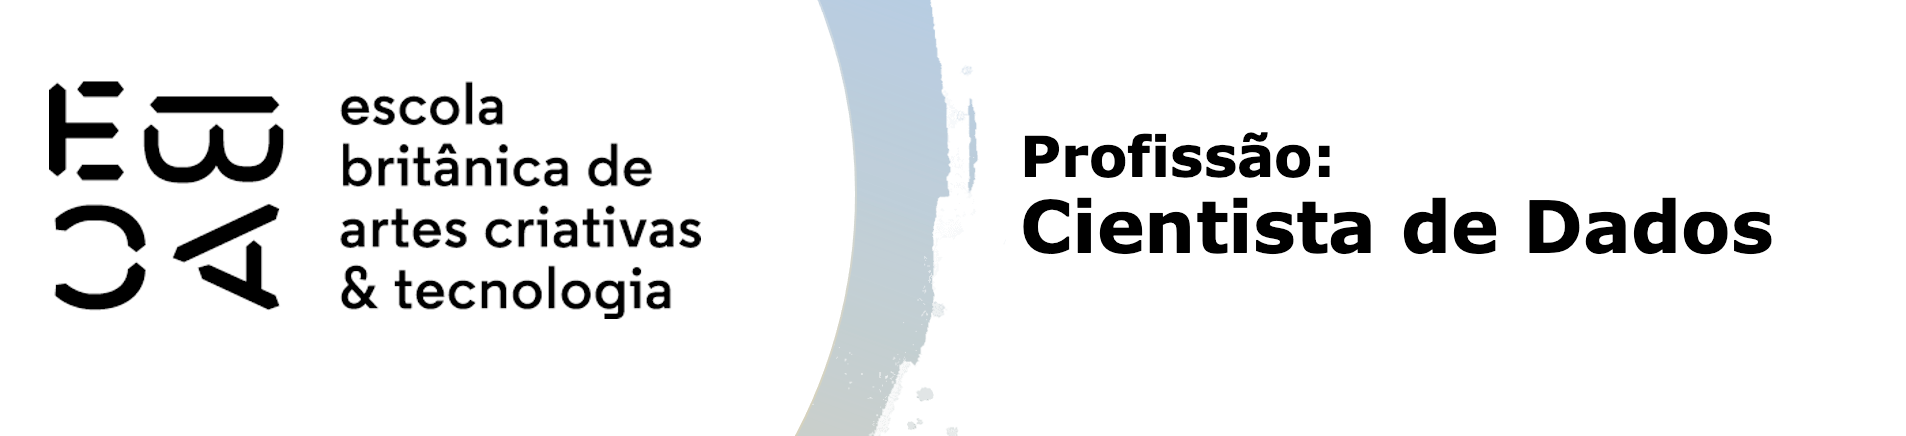

# Tarefa II

Ainda sobre a base da NFP vista na tarefa passada:

|Campo|Descrição|
|:-|:-|
|CNPJ emit.| CNPJ do emitente da nota|
|Emitente| Nome fantasia do emitente da nota|
|No.| Número da nota fiscal|
|Data Emissão| Data de emissão da nota fiscal|
|Valor NF| Valor da nota fiscal|
|Data Registro| Data de registro no sistema da NFP|
|Créditos| Valor dos créditos (doação)|
|Situação do Crédito| Se o crédito já foi pago, está sendo processado etc.|
|Ano| Ano da emissão da nota|
|Semestre| Semestre da emissão da nota|
|Retorno| Valor do crédito dividido pelo valor da nota|
|flag_credito| Indicadora se a nota possui crédito positivo|
|categoria| Categorização da nota |

**OBJETIVO:** Algumas notas não dão retorno, o que pode ocorrer por diversos motivos, um deles seria a ocorrência de produtos não incentivados como cigarros e bebidas alcólicas. O nosso objetivo é tentar prever que tipo de nota tem maior ou menor propensão a fornecer créditos.

**Observação**: Esta é uma base real, havendo características de acordo. Pode haver uma variabilidade difícil de explicar, em parte por causa de uma freqüência de notas inconstante no tempo (por diversos motivos), em parte por haverem informações importantes, protegidas pela LGPD, não constantes na base, que pode interferir no crédito gerado, o que vai ocasionar uma variabilidade difícil de se explicar. *Welcome to the jungle*, A vida real é assim :)

In [382]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from woe_iv_bin import categorical_woe

In [384]:
df = pd.read_pickle('base_nfp.pkl')
df

,CNPJ emit.,Emitente,No.,Data Emissão,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,Retorno,flag_credito,categoria
0,03.476.811/0741-98,DIA BRASIL SOCIEDADE LIMITADA,537,2017-06-30,24.68,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Mercado
1,43.101.310/0001-05,AUTO POSTO ZANWAL LTDA EPP,2894,2017-06-30,50.00,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Auto posto
2,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,699,2017-06-30,27.00,2017-06-30,0.44,Liberado,2017,1,0.016296,1,Restaurantes
3,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,698,2017-06-30,111.50,2017-06-30,1.81,Liberado,2017,1,0.016233,1,Restaurantes
4,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,694,2017-06-30,125.00,2017-06-30,2.03,Liberado,2017,1,0.016240,1,Restaurantes
...,...,...,...,...,...,...,...,...,...,...,...,...,...
187641,22.172.203/0004-40,B.BLEND MAQUINAS E BEBIDAS S. A.,180264,2021-01-07,252.84,2021-01-07,0.00,Liberado,2021,2,0.000000,0,não definido
187642,71.676.316/0005-70,SUPERMERCADOS MAMBO LTDA.,348953,2021-01-07,373.65,2021-01-07,0.00,Liberado,2021,2,0.000000,0,Mercado
187643,61.585.865/0240-93,RAIADROGASIL S/A,190447,2021-01-07,130.71,2021-01-07,0.00,Liberado,2021,2,0.000000,0,Farmácia
187644,67.616.128/0001-55,AYUMI SUPERMERCADOS LTDA - 1,51004,2021-01-07,43.16,2021-01-07,0.00,Liberado,2021,2,0.000000,0,Mercado


In [386]:
df = df[df['Data Emissão'] >= '2020-01-01']

print(f"Menor data de emissão: {df['Data Emissão'].min()}")  
print(f"Maior data de emissão: {df['Data Emissão'].max()}")

Menor data de emissão: 2020-01-01 00:00:00
Maior data de emissão: 2021-12-31 00:00:00


## Criando variáveis

**Variáveis temporais**: É possível que haja alguma regra de liberação de créditos de acordo com o dia do mês, o dia da semana, fim de semana (sim ou não), ou até alterações temporais da regra. Vamos criar as seguintes variáveis para testar estas hipóteses:

- Dia da semana
- Dummy para fim de semana
- Dia do mês
- Mês (já na base)
- Trimestre
- Ano (já na base)

**Valor da nota**: Vamos criar também algumas variáveis para resumir o valor da nota, e posteriormente criar uma intuição sobre categorizações de variáveis contínuas.

- Crie categorizações da variável ```Valor NF```, por quantís, em 5, 10, 20 e 50 categorias.

In [389]:
df['Dia da Semana'] = df['Data Emissão'].dt.dayofweek
df['Fim de Semana'] = df['Dia da Semana'].isin([5, 6]).astype(int)
df['Dia do Mês'] = df['Data Emissão'].dt.day
df['Trimestre'] = df['Data Emissão'].dt.quarter
df['Mês'] = df['Data Emissão'].dt.month
df['Ano'] = df['Data Emissão'].dt.year

df['Valor NF Cat 5'] = pd.qcut(df['Valor NF'], q=5, labels=False)
df['Valor NF Cat 10'] = pd.qcut(df['Valor NF'], q=10, labels=False)
df['Valor NF Cat 20'] = pd.qcut(df['Valor NF'], q=20, labels=False)
df['Valor NF Cat 50'] = pd.qcut(df['Valor NF'], q=50, labels=False)

df

,CNPJ emit.,Emitente,No.,Data Emissão,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,...,categoria,Dia da Semana,Fim de Semana,Dia do Mês,Trimestre,Mês,Valor NF Cat 5,Valor NF Cat 10,Valor NF Cat 20,Valor NF Cat 50
64598,05.234.750/0001-41,TX BURGER LTDA,77882,2020-01-01,78.80,2020-08-01,0.0,A Calcular,2020,2,...,não definido,2,0,1,1,1,2,5,11,27
64599,47.508.411/1476-88,CIA BRASILEIRA DE DISTRIBUICAO,20087,2020-01-01,22.71,2020-01-01,0.0,A Calcular,2020,2,...,Mercado,2,0,1,1,1,0,1,3,9
64600,09.060.964/0108-39,PIMENTA VERDE ALIMENTOS LTDA,82366,2020-01-01,35.90,2020-08-01,0.0,A Calcular,2020,2,...,Alimentos,2,0,1,1,1,1,3,6,15
64601,61.412.110/0307-39,DROGARIA SAO PAULO S A,234178,2020-01-01,21.77,2020-08-01,0.0,A Calcular,2020,2,...,Farmácia,2,0,1,1,1,0,1,3,8
64602,46.952.032/0001-98,PANIFICADORA E CONFEITARIA QUELUZ LTDA,3305,2020-01-01,80.95,2020-08-01,0.0,A Calcular,2020,2,...,Restaurantes,2,0,1,1,1,2,5,11,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187641,22.172.203/0004-40,B.BLEND MAQUINAS E BEBIDAS S. A.,180264,2021-01-07,252.84,2021-01-07,0.0,Liberado,2021,2,...,não definido,3,0,7,1,1,4,8,17,42
187642,71.676.316/0005-70,SUPERMERCADOS MAMBO LTDA.,348953,2021-01-07,373.65,2021-01-07,0.0,Liberado,2021,2,...,Mercado,3,0,7,1,1,4,9,18,45
187643,61.585.865/0240-93,RAIADROGASIL S/A,190447,2021-01-07,130.71,2021-01-07,0.0,Liberado,2021,2,...,Farmácia,3,0,7,1,1,3,7,14,35
187644,67.616.128/0001-55,AYUMI SUPERMERCADOS LTDA - 1,51004,2021-01-07,43.16,2021-01-07,0.0,Liberado,2021,2,...,Mercado,3,0,7,1,1,1,3,7,18


## Calcule o IV de todas essas variáveis

Sugestão: Construa um metadados e tente utilizar uma função como a que foi utilizada durante a aula. Você vai conseguir fazer esse cálculo para as variáveis uma a uma, mas em casos reais em que vamos mais além na criação de variáveis, podemos ter centenas, ou até milhares de variáveis, esses cálculos *precisam* ser automáticos nesses casos.

In [392]:
metadados= pd.DataFrame({'dyypes': df.dtypes})
metadados['papel']= metadados.index.map(lambda x: 'resposta' if x in ['Retorno', 'flag_credito'] else 'covariavel')
metadados['nunique']= df.nunique()

metadados

,dyypes,papel,nunique
CNPJ emit.,object,covariavel,16010
Emitente,object,covariavel,12196
No.,int64,covariavel,71685
Data Emissão,datetime64[ns],covariavel,731
Valor NF,float64,covariavel,28381
Data Registro,datetime64[ns],covariavel,734
Créditos,float64,covariavel,7845
Situação do Crédito,category,covariavel,3
Ano,int32,covariavel,2
Semestre,int64,covariavel,2


In [394]:
def IV(tabela: pd.DataFrame, variavel: str, resposta: str) -> float:
    """
    Calcula o Information Value (IV) para uma variável em relação à variável de resposta.

    Args:
        tabela (pd.DataFrame): O DataFrame contendo os dados.
        variavel (str): O nome da variável para a qual calcular o IV.
        resposta (str): O nome da variável de resposta (binária).

    Returns:
        float: O valor do IV calculado.
    """
    tab = pd.crosstab(index=tabela[variavel], columns=tabela[resposta], margins=True, margins_name="Total")
    tab['perc_nao_evento'] = tab[0] / tab.loc['Total', 0]
    tab['perc_evento'] = tab[1] / tab.loc['Total', 1]
    tab['WOE'] = np.log(tab['perc_evento'].replace(0, np.nan) / tab['perc_nao_evento'].replace(0, np.nan))
    tab['IV parcial'] = (tab['perc_evento'] - tab['perc_nao_evento']) * tab['WOE']

    return tab['IV parcial'].sum()

In [396]:
metadados['IV']= [f'{IV(tabela=df, variavel=x, resposta= 'flag_credito'):.2%}' for x in metadados.index]
metadados

,dyypes,papel,nunique,IV
CNPJ emit.,object,covariavel,16010,116.35%
Emitente,object,covariavel,12196,207.02%
No.,int64,covariavel,71685,4.69%
Data Emissão,datetime64[ns],covariavel,731,11.47%
Valor NF,float64,covariavel,28381,40.45%
Data Registro,datetime64[ns],covariavel,734,11.06%
Créditos,float64,covariavel,7845,0.00%
Situação do Crédito,category,covariavel,3,0.00%
Ano,int32,covariavel,2,0.32%
Semestre,int64,covariavel,2,0.49%


## Conclua

- Quais variáveis parecem apresentar maior poder de discriminação segundo o IV?
- Quando categorizamos variáveis contínuas parece haver alguma relação entre o número de categorias e o IV?

<div style="color: #1f77b4; font-size: 15px; font-weight: bold;">
 As variáveis <span style="color: black;"><b>Data Emissão</b></span> e <span style="color: black;"><b>categoria</b></span> se destacam como as que apresentam o maior poder de discriminação, conforme indicado pelos valores do IV. Esses resultados sugerem que essas variáveis têm uma capacidade significativa de diferenciar entre os eventos de interesse.
</div>

<div style="color: #1f77b4; font-size: 15px; font-weight: bold;">
As variáveis <span style="color: black;"><b>Data Emissão</b></span> e <span style="color: black;"><b>categoria</b></span> demonstram um significativo poder de discriminação de acordo com o IV. A categorização da variável <span style="color: black;"><b>Valor NF</b></span> em quantis reforça a ideia de que um número maior de categorias pode melhorar a relação entre a variável e o IV, sugerindo que a discretização adequada de variáveis contínuas pode aumentar a eficiência na modelagem.
</div>

## Descritiva simples no tempo

Para compor a análise que virá a seguir, faça uma análise descritiva básica no tempo - utilize trimestre como agregação (ou uma média móvel por trimestre, como preferir) e avalie graficamente:

- A quantidade de notas registradas na base por período
- A quantidade de notas por categoria e por período
- A proporção de notas com crédito por categoria por período

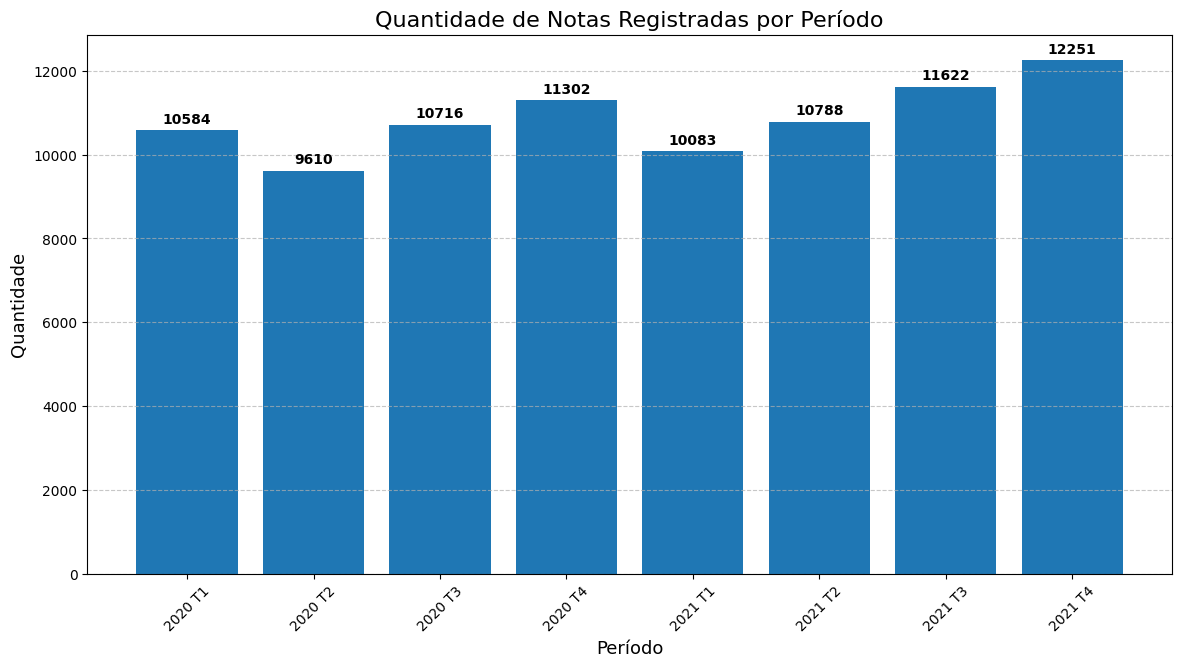

In [402]:
labels = [f"{ano} T{tri}" for ano, tri in df_grouped.index]

fig, ax = plt.subplots(figsize=(14, 7))

colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(df_grouped)))
bars = ax.bar(labels, df_grouped.values)

ax.bar_label(bars, padding=3, fontsize=10, fontweight='bold')

ax.set_title('Quantidade de Notas Registradas por Período', fontsize=16)
ax.set_xlabel('Período', fontsize=13)
ax.set_ylabel('Quantidade', fontsize=13)

ax.tick_params(axis='x', labelrotation=45, labelsize=10)
ax.tick_params(axis='y', labelsize=10)
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [404]:
df = df.assign(Periodo=df[['Ano', 'Trimestre']].astype(dtype=str).agg('_'.join, axis=1))
df_cat = df.groupby(by=['categoria', 'Periodo']).agg(Quantidade=('No.', 'count')).reset_index()

with pd.option_context('display.max_rows', None):
    display(df_cat)

,categoria,Periodo,Quantidade
0,Alimentos,2020_1,701
1,Alimentos,2020_2,562
2,Alimentos,2020_3,553
3,Alimentos,2020_4,685
4,Alimentos,2021_1,581
5,Alimentos,2021_2,605
6,Alimentos,2021_3,674
7,Alimentos,2021_4,689
8,Auto posto,2020_1,88
9,Auto posto,2020_2,62


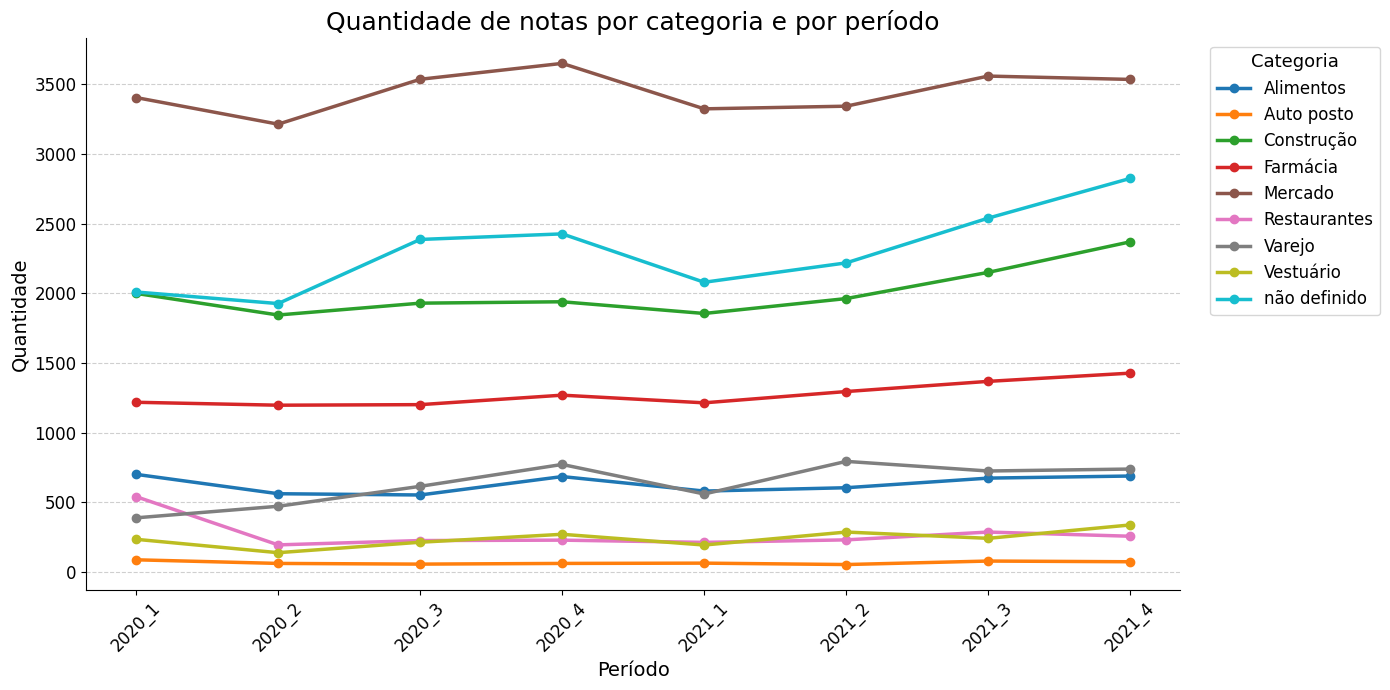

In [406]:
fig, ax = plt.subplots(figsize=(14, 7))

df_cat.pivot(index='Periodo', columns='categoria', values='Quantidade').plot(
    ax=ax,
    linewidth=2.5,
    marker='o',
    markersize=6,
    colormap='tab10' 
)

ax.set_title('Quantidade de notas por categoria e por período', fontsize=18)
ax.set_xlabel('Período', fontsize=14)
ax.set_ylabel('Quantidade', fontsize=14)
ax.grid(axis='y', linestyle='--', alpha=0.6)

ax.tick_params(axis='x', rotation=45, labelsize=12)
ax.tick_params(axis='y', labelsize=12)

ax.legend(title='Categoria', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=12, title_fontsize=13)

ax.spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()

categoria,Alimentos,Auto posto,Construção,Farmácia,Mercado,Restaurantes,Varejo,Vestuário,não definido
Periodo,,,,,,,,,
2020_1,0.11,0.0048,0.2,0.049,0.32,0.098,0.021,0.016,0.18
2020_2,0.098,0.0056,0.21,0.067,0.38,0.041,0.019,0.0062,0.17
2020_3,0.087,0.0038,0.2,0.06,0.37,0.042,0.02,0.0097,0.21
2020_4,0.099,0.0028,0.18,0.097,0.35,0.035,0.022,0.013,0.2
2021_1,0.089,0.0026,0.2,0.09,0.39,0.031,0.017,0.0087,0.17
2021_2,0.083,0.0017,0.2,0.12,0.37,0.033,0.017,0.012,0.15
2021_3,0.088,0.0045,0.21,0.13,0.33,0.04,0.018,0.014,0.17
2021_4,0.087,0.0034,0.21,0.13,0.32,0.032,0.016,0.013,0.18


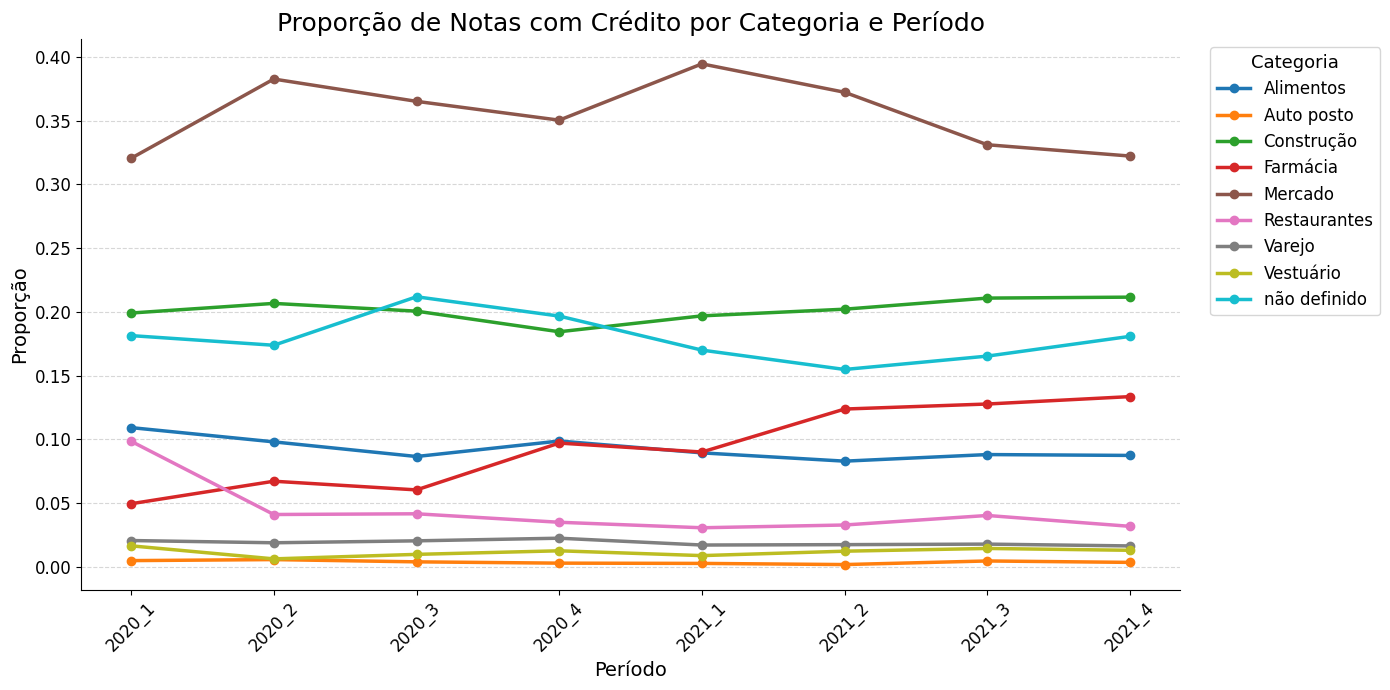

In [408]:
df_cat_credito = df.groupby(by=["categoria", "Periodo"])["flag_credito"].sum().reset_index(name='Quantidade')

df_perc_cat_credito = pd.crosstab(
    index=df_cat_credito.Periodo, 
    columns=df_cat_credito.categoria, 
    values=df_cat_credito.Quantidade, 
    aggfunc='sum', 
    normalize="index"
)
display(df_perc_cat_credito.map(lambda x: f'{x:.2}'))

fig, ax = plt.subplots(figsize=(14, 7))

df_perc_cat_credito.plot(
    ax=ax,
    linewidth=2.5,
    marker='o',
    markersize=6,
    colormap='tab10'  
)

ax.set_title('Proporção de Notas com Crédito por Categoria e Período', fontsize=18)
ax.set_xlabel('Período', fontsize=14)
ax.set_ylabel('Proporção', fontsize=14)
ax.grid(axis='y', linestyle='--', alpha=0.5)

ax.tick_params(axis='x', rotation=45, labelsize=12)
ax.tick_params(axis='y', labelsize=12)

ax.legend(title='Categoria', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=12, title_fontsize=13)

ax.spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()

## Avalie o WOE e o IV no tempo

Avalie o WOE e o IV no tempo da variável ```categoria```.

In [411]:
tab= pd.crosstab(index=[df['Periodo'], df['categoria']], columns= df.flag_credito)

tab

flag_credito             0     1
Periodo categoria               
2020_1  Alimentos      202   499
        Auto posto      66    22
        Construção    1089   910
        Farmácia       992   226
        Mercado       1939  1465
...                    ...   ...
2021_4  Mercado       1837  1697
        Restaurantes    90   167
        Varejo         653    86
        Vestuário      270    68
        não definido  1872   952

[72 rows x 2 columns]

In [413]:
tab['total_nao_evento'] = tab.groupby(by='Periodo')[0].transform('sum')
tab['perc_nao_evento'] = tab[0] / tab['total_nao_evento']

tab['total_evento'] = tab.groupby(by='Periodo')[1].transform('sum')
tab['perc_evento'] = tab[1] / tab['total_evento']

tab['WOE'] = np.log(tab['perc_evento'] / tab['perc_nao_evento'])
tab['IV parcial'] = (tab['perc_evento'] - tab['perc_nao_evento']) * tab['WOE']

with pd.option_context('display.max_rows', len(tab)):
    display(tab)

flag_credito             0     1  total_nao_evento  perc_nao_evento  \
Periodo categoria                                                     
2020_1  Alimentos      202   499              6014         0.033588   
        Auto posto      66    22              6014         0.010974   
        Construção    1089   910              6014         0.181077   
        Farmácia       992   226              6014         0.164948   
        Mercado       1939  1465              6014         0.322414   
        Restaurantes    91   450              6014         0.015131   
        Varejo         295    94              6014         0.049052   
        Vestuário      160    75              6014         0.026605   
        não definido  1180   829              6014         0.196209   
2020_2  Alimentos      213   349              6049         0.035212   
        Auto posto      42    20              6049         0.006943   
        Construção    1108   736              6049         0.183171   
        Farmácia       958   239              6049         0.158373   
        Mercado       1850  1363              6049         0.305836   
        Restaurantes    49   146              6049         0.008101   
        Varejo         405    67              6049         0.066953   
        Vestuário      117    22              6049         0.019342   
        não definido  1307   619              6049         0.216069   
2020_3  Alimentos      170   383              6289         0.027031   
        Auto posto      40    17              6289         0.006360   
        Construção    1041   888              6289         0.165527   
        Farmácia       934   267              6289         0.148513   
        Mercado       1918  1617              6289         0.304977   
        Restaurantes    42   184              6289         0.006678   
        Varejo         525    90              6289         0.083479   
        Vestuário      171    43              6289         0.027190   
        não definido  1448   938              6289         0.230243   
2020_4  Alimentos      196   489              6346         0.030886   
        Auto posto      48    14              6346         0.007564   
        Construção    1025   914              6346         0.161519   
        Farmácia       788   481              6346         0.124173   
        Mercado       1912  1737              6346         0.301292   
        Restaurantes    56   173              6346         0.008824   
        Varejo         661   111              6346         0.104160   
        Vestuário      209    62              6346         0.032934   
        não definido  1451   975              6346         0.228648   
2021_1  Alimentos      172   409              5507         0.031233   
        Auto posto      52    12              5507         0.009443   
        Construção     954   901              5507         0.173234   
        Farmácia       802   412              5507         0.145633   
        Mercado       1517  1806              5507         0.275468   
        Restaurantes    73   140              5507         0.013256   
        Varejo         482    78              5507         0.087525   
        Vestuário      154    40              5507         0.027964   
        não definido  1301   778              5507         0.236245   
2021_2  Alimentos      218   387              6118         0.035633   
        Auto posto      46     8              6118         0.007519   
        Construção    1018   944              6118         0.166394   
        Farmácia       717   578              6118         0.117195   
        Mercado       1603  1739              6118         0.262014   
        Restaurantes    78   153              6118         0.012749   
        Varejo         713    81              6118         0.116541   
        Vestuário      230    57              6118         0.037594   
        não definido  1495   723              6118         0.244361   
2021_3  Alimentos      2

In [415]:
tab.columns.name= None
tab= tab.reset_index()
tab

,Periodo,categoria,0,1,total_nao_evento,perc_nao_evento,total_evento,perc_evento,WOE,IV parcial
0,2020_1,Alimentos,202,499,6014,0.033588,4570,0.109190,1.178915,0.089128
1,2020_1,Auto posto,66,22,6014,0.010974,4570,0.004814,-0.824035,0.005076
2,2020_1,Construção,1089,910,6014,0.181077,4570,0.199125,0.095006,0.001715
3,2020_1,Farmácia,992,226,6014,0.164948,4570,0.049453,-1.204611,0.139127
4,2020_1,Mercado,1939,1465,6014,0.322414,4570,0.320569,-0.005740,0.000011
...,...,...,...,...,...,...,...,...,...,...
67,2021_4,Mercado,1837,1697,6986,0.262954,5265,0.322317,0.203555,0.012084
68,2021_4,Restaurantes,90,167,6986,0.012883,5265,0.031719,0.901011,0.016971
69,2021_4,Varejo,653,86,6986,0.093473,5265,0.016334,-1.744403,0.134560
70,2021_4,Vestuário,270,68,6986,0.038649,5265,0.012915,-1.096087,0.028206


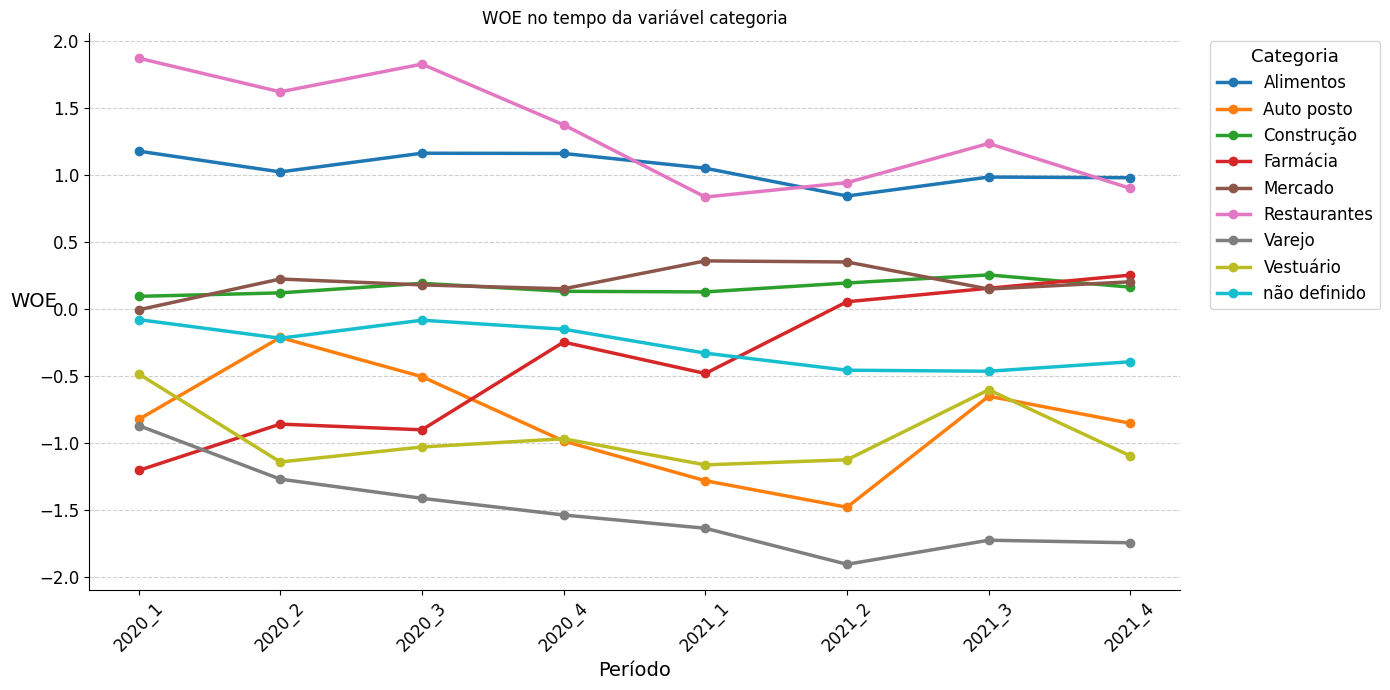

In [417]:
fig, ax = plt.subplots(figsize=(14, 7))
tab.pivot(columns='categoria', index='Periodo', values='WOE').plot.line(
    ax=ax,
    linewidth=2.5,
    marker='o',
    markersize=6,
    colormap='tab10'
)

ax.set_title('WOE no tempo da variável categoria')
ax.set_xlabel('Período', fontsize=14)
ax.set_ylabel('WOE', fontsize=14, rotation=0)
ax.grid(axis='y', linestyle='--', alpha=0.6)

ax.tick_params(axis='x', rotation=45, labelsize=12)
ax.tick_params(axis='y', labelsize=12)

ax.legend(title='Categoria', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=12, title_fontsize=13)

ax.spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()

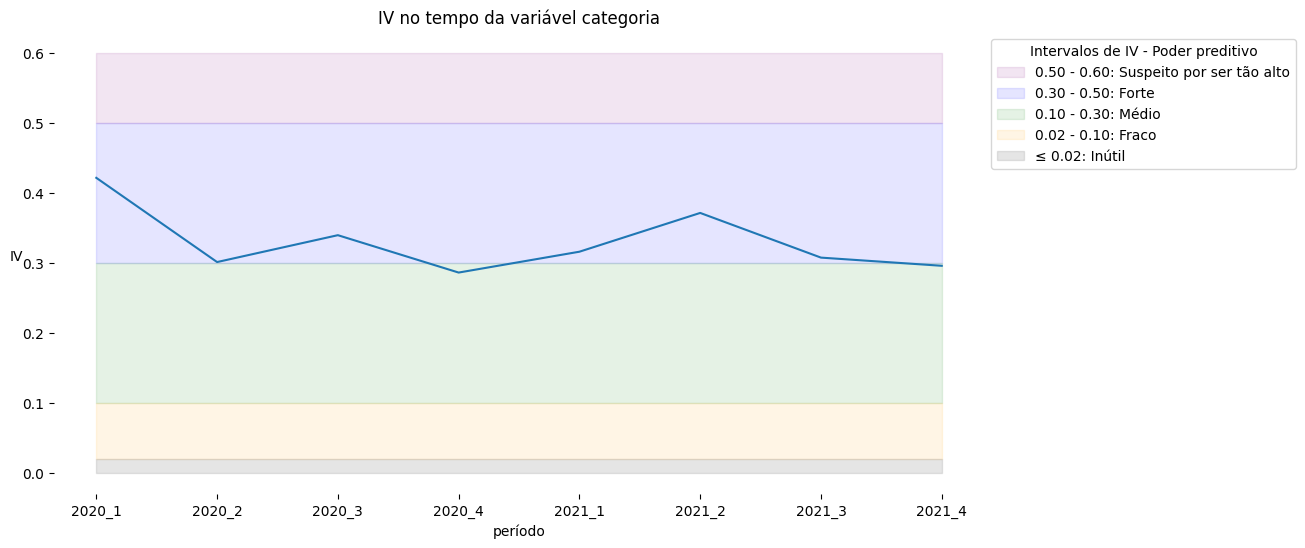

In [419]:
tab_iv = tab.groupby(by="Periodo")["IV parcial"].sum()

ax = tab_iv.plot.line(figsize=(12, 6), label="")

plt.title("IV no tempo da variável categoria") 
plt.xlabel(xlabel="período") 
plt.ylabel(ylabel="IV", rotation=0)  

a = [.02] * len(tab_iv.index)  
b = [.1] * len(tab_iv.index) 
c = [.3] * len(tab_iv.index) 
d = [.5] * len(tab_iv.index)  
e = [.6] * len(tab_iv.index)  

ax.fill_between(x=tab_iv.index, y1=d, y2=e, color='purple', alpha=.1, label="0.50 - 0.60: Suspeito por ser tão alto") 
ax.fill_between(x=tab_iv.index, y1=c, y2=d, color='blue', alpha=.1, label="0.30 - 0.50: Forte")  
ax.fill_between(x=tab_iv.index, y1=b, y2=c, color='green', alpha=.1, label="0.10 - 0.30: Médio")  
ax.fill_between(x=tab_iv.index, y1=a, y2=b, color='orange', alpha=.1, label="0.02 - 0.10: Fraco")  
ax.fill_between(x=tab_iv.index, y1=a, color='grey', alpha=.2, label="≤ 0.02: Inútil")  

plt.legend(title="Intervalos de IV - Poder preditivo", bbox_to_anchor=(1, 1), loc="upper left") 

ax.spines[:].set_visible(False) 
plt.show() 

## Conclua

- Quais categorias parece ter maior proporção de notas com retornos maiores que zero?
- Essas diferenças são estáveis no tempo?

<div style="color: #1f77b4; font-size: 15px; font-weight: bold;">
As categorias <span style="color: black;"><b>Mercado</b></span> ,<span style="color: black;"><b>Construção</b></span> e categoria <span style="color: black;"><b>não definida</b></span>  apresentam as maiores proporções de notas com retornos acima de zero. Esses resultados sugerem que essas categorias têm um desempenho financeiro relativamente melhor em comparação com outras.
</div>

<div style="color: #1f77b4; font-size: 15px; font-weight: bold;">
As diferenças observadas nas proporções de notas com retornos acima de zero se mantêm estáveis ao longo do período de análise a partir de 2020, com pequenas oscilações. É importante considerar que, desde janeiro de 2020, o perfil do público parece ter se aproximado do público atual (2022), possivelmente devido a fatores como a pandemia e o crescimento do público. No entanto, ao analisar a base de dados como um todo, podemos notar um desbalanceamento significativo que pode influenciar os resultados de forma considerável.
</div>

Dicas:<br>
- Considere que a quantidade de notas vem aumentando
- Considere que há períodos bem atípicos no histórico
- Considere que a partir de janeiro de 2020 o público é mais parecido com o público atual (2022), seja por pandemia, seja por crescimento do público, e considere os dados dessa data em diante na sua conclusão.

<div style="color: #1f77b4; font-size: 15px; font-weight: bold;">
As categorias <span style="color: black;"><b>Mercado</b></span>, <span style="color: black;"><b>Construção</b></span> e categoria <span style="color: black;"><b>não definida</b></span> destacam-se por apresentar a maior proporção de notas com retornos acima de zero. As diferenças nas proporções observadas a partir de 2020 se mantêm estáveis ao longo do tempo, com pequenas oscilações. Contudo, ao considerar a totalidade da base de dados, é evidente um desbalanceamento que pode impactar de forma significativa a análise.
</div>